In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

In [15]:
# Step 1: Load Dataset
df = pd.read_csv("sales_data.csv")  # Replace with actual filename
print(df.head())
print(df.info())
print(df.describe())

   item_id        date  month  year   location                  category  \
0   923713  2023-11-20     11  2023  Bangalore        Sports and outdoor   
1   100796  2023-06-09      6  2023      Delhi            Toys and games   
2   451769  2023-07-27      7  2023  Hyderabad                   Grocery   
3   639741  2022-08-25      8  2022    Kolkata  Beauty and personal care   
4   923713  2023-08-26      8  2023    Kolkata        Sports and outdoor   

                    item  sales  price  discount  total_sales_value  \
0      Fitness equipment   1272   4017        20            4087699   
1                  Games    341   3965         7            1257420   
2  Fruits and vegetables   1238    474        12             516394   
3         Men's grooming   2088   1528        10            2871417   
4      Fitness equipment   2343   4469        29            7434315   

   profit_margin  advertising_spend  
0           3696               8592  
1           1920               9881  
2 

In [16]:
# Step 2: EDA & Preprocessing
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 item_id              0
date                 0
month                0
year                 0
location             0
category             0
item                 0
sales                0
price                0
discount             0
total_sales_value    0
profit_margin        0
advertising_spend    0
dtype: int64


In [17]:
# Remove duplicate rows
df = df.drop_duplicates()

#Step 4: Choose & Train ML Model 🤖



In [18]:
# Encode categorical columns
label_encoders = {}
for col in ['location', 'category', 'item']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Select only int64 features for prediction
features = ['item_id', 'month', 'year', 'sales', 'price', 'discount', 'profit_margin', 'advertising_spend']
X = df[features]
y = df['total_sales_value']

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,  # Prevents overfitting
    min_samples_split=5,  # Controls tree complexity
    min_samples_leaf=3,  # Ensures enough data in leaves
    random_state=42
)
rf_model.fit(X_train, y_train)


# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Step 5: Evaluation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Store results
results = {"R2 Score": r2, "MAE": mae, "MSE": mse}
print(f"Random Forest: R2={r2:.4f}, MAE={mae:.4f}, MSE={mse:.4f}")

Random Forest: R2=0.9982, MAE=81274.0983, MSE=15112502546.6520


#Step 5: Model Evaluation 📊

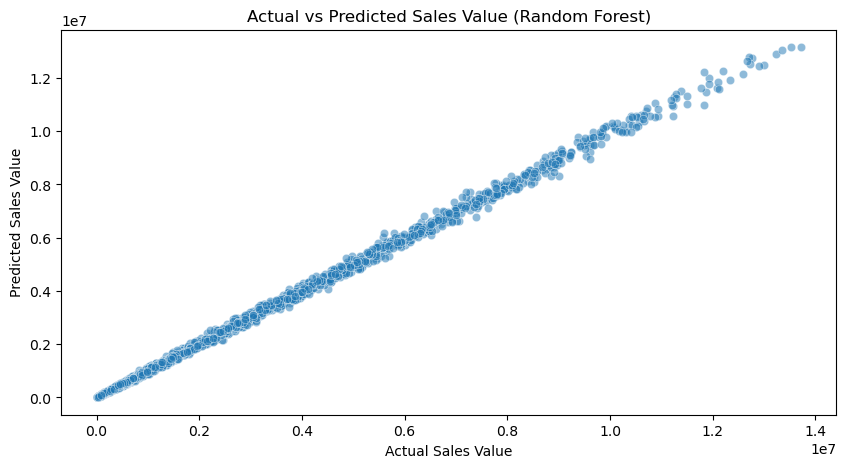

In [20]:
plt.figure(figsize=(10, 5))

# Use rf_model directly
sns.scatterplot(x=y_test, y=rf_model.predict(X_test), alpha=0.5)

plt.xlabel("Actual Sales Value")
plt.ylabel("Predicted Sales Value")
plt.title("Actual vs Predicted Sales Value (Random Forest)")
plt.show()

In [22]:
import joblib

# Save the trained Random Forest model
joblib.dump(rf_model, 'sales_prediction_model_Original.pkl')

['sales_prediction_model_Original.pkl']

Step 6: Results & Visualization 📈

In [9]:
# Predict sales for each item_id

# Decode categorical columns back to original values
predictions_df = df[['item_id', 'item', 'category', 'total_sales_value']].copy()

# Convert back to original categorical names
predictions_df['item'] = label_encoders['item'].inverse_transform(df['item'])
predictions_df['category'] = label_encoders['category'].inverse_transform(df['category'])

# Predict sales
predictions_df['Predicted Sales'] = rf_model.predict(X)

# Add status column to show increase/decrease with emoji
predictions_df['Trend'] = predictions_df.apply(
    lambda row: "🟢 Increasing" if row['Predicted Sales'] > row['total_sales_value'] else "🔴 Decreasing", axis=1
)

# Print first few rows
print(predictions_df.head())

   item_id                   item                  category  \
0   923713      Fitness equipment        Sports and outdoor   
1   100796                  Games            Toys and games   
2   451769  Fruits and vegetables                   Grocery   
3   639741         Men's grooming  Beauty and personal care   
4   923713      Fitness equipment        Sports and outdoor   

   total_sales_value  Predicted Sales         Trend  
0            4087699     4.225243e+06  🟢 Increasing  
1            1257420     1.207024e+06  🔴 Decreasing  
2             516394     4.982455e+05  🔴 Decreasing  
3            2871417     2.945760e+06  🟢 Increasing  
4            7434315     7.598580e+06  🟢 Increasing  


In [10]:
# Save predictions
#predictions_df.to_csv("sales_predictions.csv", index=False)

In [11]:
import joblib

# Load the model correctly
model = joblib.load("sales_prediction_model_new.pkl")

# Verify model type
print(type(model))  # Should be <class 'sklearn.ensemble._forest.RandomForestRegressor'>

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [12]:
def predict_sales(item_id, month, year, sales, price, discount, profit_margin, advertising_spend):
    feature_columns = ['item_id', 'month', 'year', 'sales', 'price', 'discount', 'profit_margin', 'advertising_spend']
    
    # Create DataFrame with correct structure
    new_data = pd.DataFrame([[item_id, month, year, sales, price, discount, profit_margin, advertising_spend]], 
                            columns=feature_columns)
    
    # Ensure numeric types
    new_data = new_data.astype(float)
    
    # Predict sales
    predicted_sales = model.predict(new_data)[0]

    # Calculate total sales value
    total_sales_value = int(sales * price * (1 - discount / 100))

    # Determine trend
    trend = "🟢 Increasing" if predicted_sales > total_sales_value else "🔴 Decreasing"

    # Lookup item and category using item_id
    item_info = df[df['item_id'] == item_id][['item', 'category']].iloc[0]

    # Decode item and category using label encoders
    item_name = label_encoders['item'].inverse_transform([item_info['item']])[0]
    category_name = label_encoders['category'].inverse_transform([item_info['category']])[0]

    return f"Item: {item_name} | Category: {category_name} | " \
           f"Actual Sales: {total_sales_value:,} | Predicted Sales: {predicted_sales:,.2f} | Trend: {trend}"

In [13]:
print(predict_sales(923713, 5, 2025, 100, 4017, 10, 25, 20000))

Item: Fitness equipment | Category: Sports and outdoor | Actual Sales: 361,530 | Predicted Sales: 364,183.50 | Trend: 🟢 Increasing
